In [1]:
import torch
import pytorch_lightning as pl
import yaml
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
import pickle

import pandas as pd

from models.stnp import STNP
#
from all_utils.data_utils import  load_graph_data, get_filenames

from pathlib import Path
from ast import literal_eval
import matplotlib as mpl
mpl.rcParams["font.size"]=12


MAX_LENGTH=245

In [2]:
def map_runid_to_fname(run_id, version_id=61001, run_ids_per_file=6):
  offset = version_id * (10**12)
  return (offset + ((run_id - offset -1)//run_ids_per_file) * run_ids_per_file )

In [3]:
def load_model(model, checkpoint_path):
    # x, y, y0= get_tensor(x, y)
    # y_pred= model.generate(x, y0)
    checkpoint= torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])
    return model

In [4]:
def get_sample_predictions(model, x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames, file_id, id2features:dict, n_samples, x_stats, y_stats:pd.DataFrame, category="test"):
    
    x_filename= x_filenames[file_id]
    xt_filename= xt_filenames[file_id]

    y_inc_filename= y_inc_filenames[file_id]
    y_prev_filename= y_prev_filenames[file_id]
    y0_filename= y0_filenames[file_id]
    
    y_mean, y_std= y_stats["y_mean"].values, y_stats["y_std"].values
    meta_index=int(os.path.basename(x_filename).split("_")[0])
    
    if category=="test":
        meta_df= pd.read_csv("meta_data/all_meta_df.csv", usecols=["starting_date","seasonality_min", "R0", "Susceptible", "run_ids"])
    elif category=="train":
        meta_df= pd.read_csv("meta_data/x_df.csv", usecols=["starting_date","seasonality_min", "R0", "Susceptible", "run_ids"])
    else:
        raise KeyError
    
    meta_df["run_ids"]= meta_df["run_ids"].apply(literal_eval)
    
    meta_df["file_id"]= meta_df["run_ids"].apply(lambda x: map_runid_to_fname(list(set(int(rid) for rid in x))[0]))
    

    file_id= Path(y_inc_filename).stem.split("_")[0]

    features= meta_df.query(f"file_id=={file_id}")
    
    x= np.load(x_filename)
    xt= np.load(xt_filename)
    y_inc= np.load(y_inc_filename)
    y_prev= np.load(y_prev_filename)
    
    y_hosp_inc, y_latent_inc= np.split(y_inc, 2, axis=-1)
    y_hosp_prev, y_latent_prev= np.split(y_prev, 2, axis=-1)
    y= np.concatenate([y_hosp_inc, y_hosp_prev, y_latent_inc, y_latent_prev], axis=-1)[:, :MAX_LENGTH,...]

    y0=np.load(y0_filename)
    
    xt= xt[:, :MAX_LENGTH, ...]
    
    xin=np.repeat(x[0][np.newaxis, ...], n_samples, axis=0)
    xt=np.repeat(xt[0][np.newaxis, ...], n_samples, axis=0)

    y0_in= np.repeat(y0[0].reshape(1, -1), n_samples, axis=0)

    samples= model.get_samples(xin, xt, y0_in, None, None, y_mean, y_std)
    features= features.to_dict(orient="record")[0]
    return samples, y[:,1:,...], features

In [5]:
def plot_samples(samples, y_true, state_id, features:dict, state_map):
    
    fig, ax= plt.subplots(ncols=2, nrows=2, figsize=(10,8))
    
    axs= ax.ravel()
    
    ids= [state_id, 51+state_id, 2*51+state_id, 3*51+state_id]
    comp_names=["Hospitalized incidence",  "Hospitalized prevalence", "Latent incidence", "Latent prevalence"]
    starting_date= pd.to_datetime(features["starting_date"])
    length= y_true.shape[1]
    #
    for i, (iid, name) in enumerate(zip(ids, comp_names)):
        num_samples= samples.shape[0]
        num_true_y= y_true.shape[0]
        
        end_date= pd.DateOffset(days=length-1)+ starting_date

        dates= pd.date_range(start= starting_date, end=end_date)

        for j in range(num_samples):
            axs[i].plot(dates, samples[j, :, iid], color="orange", alpha= .5, linewidth=1, label="GLEAM-AI" if j==0 else "_nolegend_")
        for j in range(num_true_y):
            axs[i].plot(dates, y_true[j , :, iid], color="green", alpha=.5, linewidth=1,  label= "GLEAM" if j==0 else "_nolegend_")
        axs[i].set_title(name)
        axs[i].set_ylim(ymin=0)
        axs[i].legend()
        plt.gcf().autofmt_xdate()
    
    #ax[1, 0].set_xlabel("Date")
    # ax[1, 1].set_xlabel("Date")
    ax[0, 0].set_ylabel("individuals")
    ax[1, 0].set_ylabel("individuals")
    plt.suptitle(f'{state_map[state_id]}, (Susceptible, seasonality_min, R0)={features["Susceptible"], features["seasonality_min"], features["R0"]}')


In [6]:
config= yaml.load(open("config.yaml", "r"), Loader= yaml.SafeLoader)

In [7]:
edge_index, edge_weight= load_graph_data(config["meta_data"]["metaPath"])

In [9]:
model= STNP(x_dim=config["model"]["x_dim"], 
                xt_dim=config["model"]["xt_dim"],
                y_dim=config["model"]["y_dim"],
                z_dim=config["model"]["z_dim"],
                r_dim=config["model"]["r_dim"],
                seq_len=config["model"]["seq_len"],
                num_nodes=config["model"]["num_nodes"],
                in_channels=config["model"]["in_channels"],
                out_channels=config["model"]["out_channels"],
                embed_out_dim=config["model"]["embed_out_dim"],
                max_diffusion_step=config["model"]["max_diffusion_step"],
                encoder_num_rnn=config["model"]["encoder_num_rnn"],
                decoder_num_rnn=config["model"]["decoder_num_rnn"],
                decoder_hidden_dims=config["model"]["decoder_hidden_dims"],
                NUM_COMP=config["model"]["NUM_COMP"],
                context_percentage=config["model"]["context_percentage"],
                lr=config["train"]["lr"],
                lr_encoder=config["train"]["lr_encoder"],
                lr_decoder=config["train"]["lr_decoder"],
                lr_milestones=config["train"]["lr_milestones"],
                lr_gamma=config["train"]["lr_gamma"],
                edge_index= edge_index, edge_weight=edge_weight)

In [10]:
with open(os.path.join(config["meta_data"]["metaPath"], "id2features.pk"), "rb") as fp:
        id2features= pickle.load(fp)
id2features= dict(id2features)
#
with open(os.path.join(config["meta_data"]["metaPath"], "state_map.pk"), "rb") as fp:
    state_map= pickle.load(fp)

In [11]:
# x_filenames, y_inc_filenames, y_prev_filenames= load_data(params["dataPath"], "val")
# x= np.load(x_filenames[0])
# y_inc= np.load(y_inc_filenames[0])
# y_prev= np.load(y_prev_filenames[0])
# y= np.concatenate([y_inc, y_prev], axis=-1)

In [12]:
# n_iter=8
# checkpoint_path= f"./logs/checkpoints/checkpoint_iter_{n_iter}.pt"
# model= load_model(model, checkpoint_path)
# #
# with open(f"logs/active_logs/active_info_iter_{n_iter}.pk", "rb") as fp:
#     data_stats= pickle.load(fp)["data_z_scores"]

In [13]:
checkpoint_file=sorted(list( Path("./logs/checkpoints").glob("*.pt")))[-1]
y_stats_filename= sorted(list(Path("./logs/active_logs").glob("y_stats*.parquet")))[-1]

model= load_model(model, checkpoint_file)

y_stats= pd.read_parquet(y_stats_filename)
print(checkpoint_file)

logs/checkpoints/checkpoint_iter_0000000001.pt


In [14]:
category="test"
x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames= get_filenames(config["meta_data"]["dataPath"], category)

In [15]:
# 29, 30, 15, 13, 12, 11, 10,9, 50

In [16]:
file_id= 50
state_id= 4
samples, y_true, features= get_sample_predictions(model, x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames, file_id, id2features, n_samples=30, x_stats=None, y_stats= y_stats, category=category)

/tmp/ipykernel_23644/3165169342.py:48: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  features= features.to_dict(orient="record")[0]


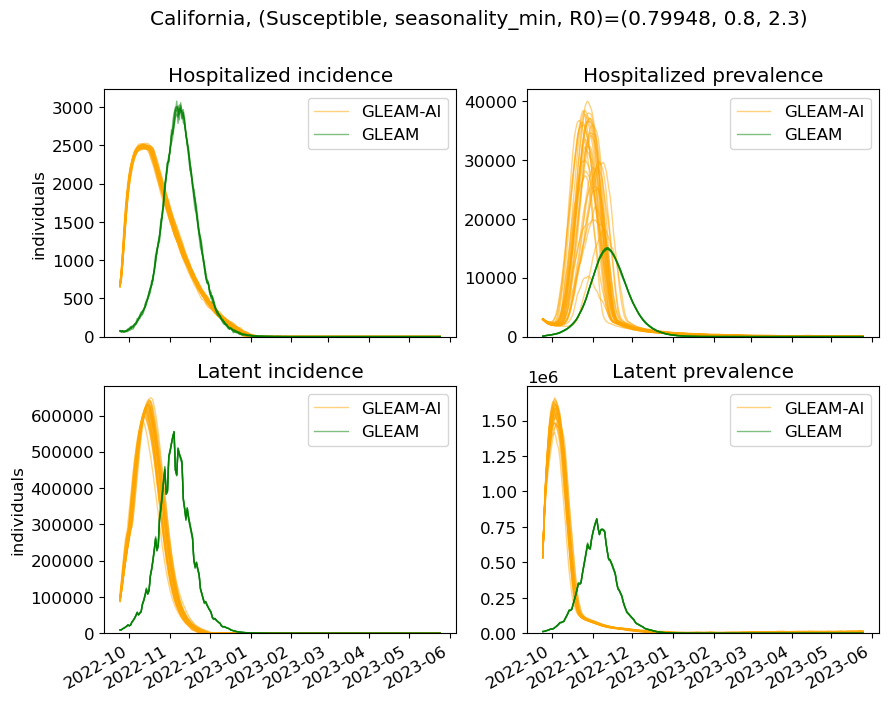

In [17]:
plot_samples(samples, y_true, state_id, features, state_map)
# plt.savefig("figs/1.jpg", dpi=300, bbox_inches="tight")

In [53]:
y0_filenames[80]

IndexError: list index out of range

In [61]:
df_meta= pd.read_csv("meta_data/all_meta_df.csv")
df_meta["run_ids"]= df_meta["run_ids"].apply(literal_eval)    
df_meta["file_id"]= df_meta["run_ids"].apply(lambda x: map_runid_to_fname(list(set(int(rid) for rid in x))[0]))
    

In [65]:
df_meta.query("file_id==61001000000896820")

,starting_date,seasonality_min,R0,fraction_susceptible,run_ids,Susceptible,Susceptible_vax,Latent,Latent_vax,Infectious_symptomatic_travel,...,Infectious_asymptomatic_vax,Hospitalized_symptomatic,Hospitalized_symptomatic_vax,Removed_symptomatic,Removed_symptomatic_vax,Removed_asymptomatic,Removed_asymptomatic_vax,Recovered,days,file_id
129715,2022-10-07,0.65,3.0,0.67,"[61001000000896821, 61001000000896822, 6100100...",0.74956,0.0,0.00022,0.0,0.000073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,279,61001000000896820


In [64]:
df_meta

,starting_date,seasonality_min,R0,fraction_susceptible,run_ids,Susceptible,Susceptible_vax,Latent,Latent_vax,Infectious_symptomatic_travel,...,Infectious_asymptomatic_vax,Hospitalized_symptomatic,Hospitalized_symptomatic_vax,Removed_symptomatic,Removed_symptomatic_vax,Removed_asymptomatic,Removed_asymptomatic_vax,Recovered,days,file_id
0,2022-09-18,0.6,1.15,0.67,"[61001000000375565, 61001000000375566, 6100100...",0.89956,0.0,0.00022,0.0,0.000073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,260,61001000000375564
1,2022-09-18,0.6,1.15,0.67,"[61001000000375553, 61001000000375554, 6100100...",0.89972,0.0,0.00014,0.0,0.000047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,260,61001000000375552
2,2022-09-18,0.6,1.20,0.67,"[61001000000375619, 61001000000375620, 6100100...",0.84948,0.0,0.00026,0.0,0.000087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,260,61001000000375618
3,2022-09-18,0.6,1.20,0.67,"[61001000000375616, 61001000000375617, 6100100...",0.84956,0.0,0.00022,0.0,0.000073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,260,61001000000375612
4,2022-09-18,0.6,1.20,0.67,"[61001000000375607, 61001000000375608, 6100100...",0.84964,0.0,0.00018,0.0,0.000060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,260,61001000000375606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141625,2022-10-08,0.9,4.00,0.67,"[61001000000774464, 61001000000774465, 6100100...",0.84964,0.0,0.00018,0.0,0.000060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,280,61001000000774462
141626,2022-10-08,0.9,4.00,0.67,"[61001000000774457, 61001000000774458, 6100100...",0.84972,0.0,0.00014,0.0,0.000047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,280,61001000000774456
141627,2022-10-08,0.9,4.00,0.67,"[61001000000774451, 61001000000774452, 6100100...",0.89948,0.0,0.00026,0.0,0.000087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,280,61001000000774450
141628,2022-10-08,0.9,4.00,0.67,"[61001000000774445, 61001000000774446, 6100100...",0.89956,0.0,0.00022,0.0,0.000073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,280,61001000000774444


In [23]:
samples[1, :10, 4]

array([4473.50100317, 1926.09118318,    0.        ,   73.2015481 ,
         77.56445599,   83.77540177,   89.84250099,  139.96204485,
        159.46197557,  197.49724034])

In [25]:
y_true[1, :10, 4]

array([ 40.05638954,  48.1398546 ,  44.92837004,  39.19624414,
        46.        ,  54.78851544,  93.70862562, 100.42549212,
       113.88421887, 135.2797092 ])

In [26]:
print(model)

STNP(
  (embed): EmbedModel(
    (recurrent): DCRNN2(
      (conv_x_z): DConv(38, 32)
      (conv_x_r): DConv(38, 32)
      (conv_x_h): DConv(38, 32)
    )
    (fc): Linear(in_features=1632, out_features=256, bias=True)
  )
  (rnn_encoder): EncoderRNN(
    (rnn): GRU(358, 100, batch_first=True)
  )
  (rnn_decoder_hosp_inc): DecoderRNN_2(
    (rnn): GRU(407, 1024, num_layers=2, batch_first=True)
    (fc_layers): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
    )
    (fc_init_val): Sequential(
      (0): Linear(in_features=51, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=51, bias=True)
    )
    (fc): Linear(in_features=1024, out_features=51, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
    (relu): ReLU()
  )
  (rnn_decoder_hosp_prev): DecoderRNN_2(
    (rnn): GRU(407, 1024, num_layers=2, batch_first=True)
    (fc_layers): Sequential(
